# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - **minimum required spend** to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in **hours** since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# A .  What to do

### Goal/Achievements
To combine transaction, demographic and offer data to determine **which demographic groups respond best to which offer type.**

### Way how to do

- **A machine learning model** that predicts **how much someone will spend based on demographics and offer type**. 
- **A model** that predicts **whether or not someone will respond to an offer**.
- **A set of heuristics** that determine **what offer you should send to each customer** (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### About Data

- **Once every few days**, Starbucks sends out **an offer to users of the mobile app**. An offer can be merely an advertisement for a drink or an actual offer such as a **discount** or **BOGO (buy one get one free)**. Some users might **not** receive any offer during certain weeks. 

- Every offer has a **validity period** before the offer expires.  

- **informational offers** have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, **you can assume the customer is feeling the influence of the offer for 7 days** after receiving the advertisement.

- transactional data showing user purchases **made on the app** including the **timestamp of purchase** and the **amount of money spent** on a purchase. 

- transactional data also has a record for each offer that a user receives as well as a record for **when a user actually views the offer**. There are also records for **when a user completes an offer**. 

- **someone using the app** might make a purchase through the app **without having received an offer or seen an offer**.

- **a user can receive an offer, never actually view the offer, and still complete the offer**. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, **the customer was not influenced by the offer because the customer never viewed the offer**.

- **Some demographic groups will make purchases even if they don't receive an offer**. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. **You'll want to try to assess what a certain demographic group will buy when not receiving any offers**.

### Question

- which demographic groups respond best to which offer type
> - *receive/view/complete*
> - *receive/view*
> - *receive/not view/complete*
> - *not receive/transaction*
> - *information/transaction*
- how much someone will spend based on demographics and offer type


# B. Data Understanding

## 1. `portfolio` Dataframe

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
portfolio = portfolio.copy()

In [5]:
portfolio['duration'] = pd.to_datetime(portfolio['duration'], format='%d').dt.day

In [6]:
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [7]:
portfolio

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## 2. `profile` Dataframe

In [8]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [9]:
profile = profile.copy()

In [10]:
profile['became_member_on']=profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


In [12]:
def generation(profile=profile):
    '''
    create 'generation' column
    imput: Profile df
    output : profile df with generation column
    '''
    bin_edges = [10,20,30,40,50,60,70,80,90,100,110,120]
    bin_names = ['10s','20s','30s','40s','50s','60s','70s','80s','90s','100s','110s']
    profile['generation'] = pd.cut(profile['age'], bin_edges, labels=bin_names)
    
    return profile

generation()

,gender,age,id,became_member_on,income,generation
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,110s
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,50s
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,110s
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,70s
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,110s
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,40s
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,60s
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,40s
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,80s


In [13]:
def loyalty(profile=profile):
    
    '''
    create 'loyalty' column, membership duration between latest membership - 'became_member_on'
    imput: profile df
    output: profile df with loyality column
    
    '''
    latest = profile.became_member_on.max()
    membership_duration = (latest - profile.became_member_on).dt.days
    profile['loyalty'] = membership_duration
    
    return profile

loyalty()    

,gender,age,id,became_member_on,income,generation,loyalty
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,110s,529
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,50s,376
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,110s,14
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,70s,443
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,110s,356
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,40s,52
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,60s,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,40s,546
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,80s,871


In [14]:
profile = profile.query('age!="118"')

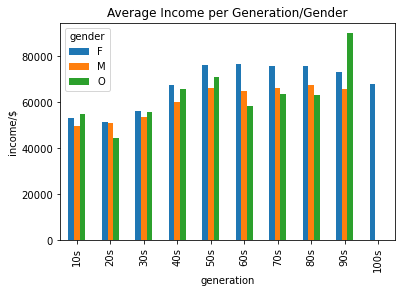

In [15]:
profile.pivot_table('income', index ='generation', columns='gender', aggfunc='mean').plot(kind='bar');
plt.title('Average Income per Generation/Gender');
plt.ylabel('income/$');

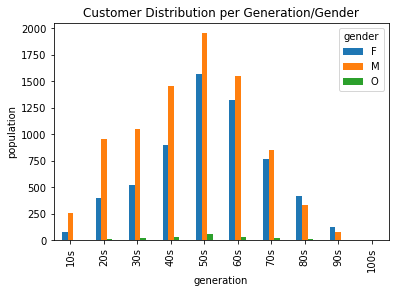

In [16]:
profile.pivot_table('income', index ='generation', columns='gender', aggfunc='count').plot(kind='bar');
plt.title('Customer Distribution per Generation/Gender');
plt.ylabel('population');

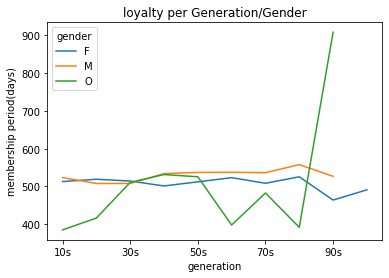

In [17]:
profile.pivot_table('loyalty', index ='generation', columns='gender', aggfunc='mean').plot();
plt.title('loyalty per Generation/Gender');
plt.ylabel('membership period(days)');

In [18]:
personal_data = profile.drop_duplicates()
personal_data

,gender,age,id,became_member_on,income,generation,loyalty
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,50s,376
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,70s,443
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,60s,91
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,60s,167
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,50s,257
...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,40s,52
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,60s,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,40s,546
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,80s,871


In [19]:
personal_data.rename(columns={'id':'person'}, inplace=True)

## 3. `transcript` Dataframe

In [20]:
transcript = transcript.copy()

In [21]:
transcript = transcript.sort_values(['person','time'])
transcript

,person,event,value,time
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372
...,...,...,...,...
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 14.23},576
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},582
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 10.12},606


In [22]:
def events_filter(event_list, df):
    
    '''
    Filter events by each event, 'offer_received','offer_viewed', 'offer_completed' and 'transaction'
    input: [event]
    output: pd.df 'event'
    '''
    event_df = df.loc[df['event'].isin([event_list])]    
    
    return event_df     

In [23]:
events_filter('transaction', transcript).shape[0]

138953

In [24]:
events_filter('offer completed', transcript).shape[0]

33579

In [25]:
offer_received=events_filter('offer received', transcript)
offer_received

,person,event,value,time
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
153401,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408
204340,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504
247879,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576
...,...,...,...,...
54574,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},168
112214,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},336
152030,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},408
202962,ffff82501cea40309d5fdd7edcca4a07,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},504


In [26]:
offer_received.time.value_counts()

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

> offers were given at the same time in 6 timings.  

In [27]:
# difference 'user id' and 'user_id'
transcript.query('index=="35749"')['value'].item()

{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}

> 'offer_id' is a reward given for completing an offer

In [28]:
def transcript_clean(df=transcript):
    '''
    clean transcript Dataframe
    '''
    # convert dict of value column to pd.Series and concat to transcript df
    transcript = pd.concat([df, df['value'].apply(pd.Series)],axis=1).sort_values(['person','time'])
    
    # offer id == null & offer_id ==not null ==> offer_id
    # otherwise ==> offer id
    transcript['offer']= np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),
                                  transcript['offer_id'], transcript['offer id'])
    
    transcript.drop(['offer id','offer_id'],axis=1,inplace=True)
    
    transcript.rename(columns={'offer':'offer_id'}, inplace=True)
    
    transcript = transcript.merge(personal_data,how='left',on='person')
    
        
    return transcript

transcript = transcript_clean()
transcript

,person,event,value,time,amount,reward,offer_id,gender,age,became_member_on,income,generation,loyalty
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,30s,461.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,30s,461.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,M,33.0,2017-04-21,72000.0,30s,461.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,30s,461.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,30s,461.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 14.23},576,14.23,NaN,NaN,F,45.0,2016-11-25,62000.0,40s,608.0
306530,ffff82501cea40309d5fdd7edcca4a07,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,F,45.0,2016-11-25,62000.0,40s,608.0
306531,ffff82501cea40309d5fdd7edcca4a07,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},582,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,F,45.0,2016-11-25,62000.0,40s,608.0
306532,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 10.12},606,10.12,NaN,NaN,F,45.0,2016-11-25,62000.0,40s,608.0


# C. Heuristic Analysys

## 1. Merge transcript + portfolio

In [29]:
transcript = transcript.merge(portfolio,how='left',on='offer_id')
transcript

,person,event,value,time,amount,reward_x,offer_id,gender,age,became_member_on,income,generation,loyalty,reward_y,channels,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,30s,461.0,0.0,"[email, mobile, social]",0.0,3.0,informational
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,30s,461.0,0.0,"[email, mobile, social]",0.0,3.0,informational
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,M,33.0,2017-04-21,72000.0,30s,461.0,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,30s,461.0,0.0,"[web, email, mobile]",0.0,4.0,informational
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,30s,461.0,0.0,"[web, email, mobile]",0.0,4.0,informational
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 14.23},576,14.23,NaN,NaN,F,45.0,2016-11-25,62000.0,40s,608.0,NaN,NaN,NaN,NaN,NaN
306530,ffff82501cea40309d5fdd7edcca4a07,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,F,45.0,2016-11-25,62000.0,40s,608.0,2.0,"[web, email, mobile]",10.0,7.0,discount
306531,ffff82501cea40309d5fdd7edcca4a07,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},582,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,F,45.0,2016-11-25,62000.0,40s,608.0,2.0,"[web, email, mobile]",10.0,7.0,discount
306532,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 10.12},606,10.12,NaN,NaN,F,45.0,2016-11-25,62000.0,40s,608.0,NaN,NaN,NaN,NaN,NaN


In [30]:
transcript.to_csv('transcript.csv', index=False)

## 2. Creation of DataFrame, Group of 'View' and 'Not view'

In [31]:
transcript = pd.read_csv('transcript.csv')
transcript=transcript.sort_values(['person','time'])
transcript

,person,event,value,time,amount,reward_x,offer_id,gender,age,became_member_on,income,generation,loyalty,reward_y,channels,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,30s,461.0,0.0,"['email', 'mobile', 'social']",0.0,3.0,informational
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,M,33.0,2017-04-21,72000.0,30s,461.0,0.0,"['email', 'mobile', 'social']",0.0,3.0,informational
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,M,33.0,2017-04-21,72000.0,30s,461.0,NaN,NaN,NaN,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,30s,461.0,0.0,"['web', 'email', 'mobile']",0.0,4.0,informational
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,M,33.0,2017-04-21,72000.0,30s,461.0,0.0,"['web', 'email', 'mobile']",0.0,4.0,informational
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 14.23},576,14.23,NaN,NaN,F,45.0,2016-11-25,62000.0,40s,608.0,NaN,NaN,NaN,NaN,NaN
306530,ffff82501cea40309d5fdd7edcca4a07,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,F,45.0,2016-11-25,62000.0,40s,608.0,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount
306531,ffff82501cea40309d5fdd7edcca4a07,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},582,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,F,45.0,2016-11-25,62000.0,40s,608.0,2.0,"['web', 'email', 'mobile']",10.0,7.0,discount
306532,ffff82501cea40309d5fdd7edcca4a07,transaction,{'amount': 10.12},606,10.12,NaN,NaN,F,45.0,2016-11-25,62000.0,40s,608.0,NaN,NaN,NaN,NaN,NaN


In [32]:
def create_group_view():
    '''
    create Group to filter view or view => complete
    '''
    # create Group df where 'offer_viewed' and 'offer_completed' are there in 'event' column
    Group = transcript[['person','offer_id','time','event','reward_x', 'amount',
                        'offer_type']][(transcript['event']=='offer viewed') | (transcript['event']=='offer completed')]
    
    Group.sort_values(['person','time']).drop_duplicates()
    
    # create 'view' column
    # 'person'+'offer_id' is first grouped(group\by method), in case a group of the same person and offer_id continued,
    # this group is offer viewed => offer completed, or offer completed => offer viewed
    # by 'shift' to identify those group
    Group['view'] = Group.groupby(['person','offer_id'])['offer_id'].shift()
    
    # change offer_id name in 'view' column to 1, otherwise 0
    Group['view'] = np.where(Group['view'] == Group['offer_id'], 1, 0)
    
    # create 'complete' column where evnet is 'offer_completed' and 'view' is 1
    # this means offer viewed => offer completed
    Group['complete'] = np.where((Group['event']=='offer completed') & (Group['view']==1), 1 ,0)
    
    # create 'respond' column where 
    Group = Group.loc[(Group.view == 1) | (Group.complete == 1)]
    
    Group = Group.merge(personal_data, how='left', on='person')
        
    return Group

group_view = create_group_view()
group_view

,person,offer_id,time,event,reward_x,amount,offer_type,view,complete,gender,age,became_member_on,income,generation,loyalty
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,offer viewed,NaN,NaN,bogo,1,0,M,33.0,2017-04-21,72000.0,30s,461.0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540,offer viewed,NaN,NaN,discount,1,0,M,33.0,2017-04-21,72000.0,30s,461.0
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,630,offer viewed,NaN,NaN,bogo,1,0,NaN,NaN,NaT,NaN,NaN,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,252,offer completed,3.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,30s,198.0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,576,offer completed,5.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,30s,198.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37628,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,414,offer viewed,NaN,NaN,discount,1,0,F,45.0,2016-11-25,62000.0,40s,608.0
37629,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,414,offer completed,2.0,NaN,discount,1,1,F,45.0,2016-11-25,62000.0,40s,608.0
37630,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,534,offer viewed,NaN,NaN,bogo,1,0,F,45.0,2016-11-25,62000.0,40s,608.0
37631,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,576,offer completed,2.0,NaN,discount,1,1,F,45.0,2016-11-25,62000.0,40s,608.0


#### group 1

In [33]:
# group_1
# view => complete
group_1 = create_group_view().query('complete == "1"').drop_duplicates()
group_1

,person,offer_id,time,event,reward_x,amount,offer_type,view,complete,gender,age,became_member_on,income,generation,loyalty
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,252,offer completed,3.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,30s,198.0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,576,offer completed,5.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,30s,198.0
5,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,576,offer completed,5.0,NaN,bogo,1,1,O,40.0,2018-01-09,57000.0,30s,198.0
6,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,54,offer completed,2.0,NaN,discount,1,1,F,59.0,2016-03-04,90000.0,50s,874.0
7,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,510,offer completed,2.0,NaN,discount,1,1,F,59.0,2016-03-04,90000.0,50s,874.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37625,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,60,offer completed,2.0,NaN,discount,1,1,F,45.0,2016-11-25,62000.0,40s,608.0
37626,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,198,offer completed,5.0,NaN,discount,1,1,F,45.0,2016-11-25,62000.0,40s,608.0
37627,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,384,offer completed,2.0,NaN,discount,1,1,F,45.0,2016-11-25,62000.0,40s,608.0
37629,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,414,offer completed,2.0,NaN,discount,1,1,F,45.0,2016-11-25,62000.0,40s,608.0


#### group 2

In [34]:
# group_2
# transact => view => complete
group_2 = create_group_view()[(create_group_view().view == 1) & (create_group_view().complete == 0)].drop_duplicates()
group_2

,person,offer_id,time,event,reward_x,amount,offer_type,view,complete,gender,age,became_member_on,income,generation,loyalty
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,offer viewed,NaN,NaN,bogo,1,0,M,33.0,2017-04-21,72000.0,30s,461.0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540,offer viewed,NaN,NaN,discount,1,0,M,33.0,2017-04-21,72000.0,30s,461.0
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,630,offer viewed,NaN,NaN,bogo,1,0,NaN,NaN,NaT,NaN,NaN,NaN
13,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,420,offer viewed,NaN,NaN,discount,1,0,F,26.0,2017-06-21,73000.0,20s,400.0
20,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,516,offer viewed,NaN,NaN,bogo,1,0,M,54.0,2016-03-31,99000.0,50s,847.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37622,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,510,offer viewed,NaN,NaN,bogo,1,0,M,34.0,2017-01-23,34000.0,30s,549.0
37624,fffad4f4828548d1b5583907f2e9906b,9b98b8c7a33c4b65b9aebfe6a799e6d9,666,offer viewed,NaN,NaN,bogo,1,0,M,34.0,2017-01-23,34000.0,30s,549.0
37628,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,414,offer viewed,NaN,NaN,discount,1,0,F,45.0,2016-11-25,62000.0,40s,608.0
37630,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,534,offer viewed,NaN,NaN,bogo,1,0,F,45.0,2016-11-25,62000.0,40s,608.0


#### group 3

In [35]:
def create_group_notview():
    '''
    create Group to filter view or not view
    '''
    # create Group df where 'offer_viewed' and 'offer_completed' are there in 'event' column
    Group_notview = transcript[['person','offer_id','time','event','channels',
                        'offer_type']][(transcript['event']=='offer received') | (transcript['event']=='offer viewed')]
    
    Group_notview.sort_values(['person','time']).drop_duplicates()
    
    # create 'view' column
    # 1st, 'person'+'offer_id' is packaged(by 'group_by' method) and sorted by 'person' and 'time,
    # in case a package make of the same person and the offer_id,
    # this group is offer received => offer viewed
    # by 'shift(-1)' to identify viewed 'offer received'
    Group_notview['receive'] = Group_notview.groupby(['person','offer_id'])['offer_id'].shift(-1)
    
    # change offer_id name in 'view' column to 1, otherwise 0
    Group_notview['receive'] = np.where(Group_notview['receive'] == Group_notview['offer_id'], 1, 0)
    
    # create 'complete' column where evnet is 'offer_completed' and 'view' is 1
    # this means offer viewed => offer completed
    Group_notview['view'] = np.where((Group_notview['event']=='offer viewed') & (Group_notview['receive']==1), 1 ,0)
    
    Group_notview['view'] = np.where((Group_notview['event']=='offer received') & (Group_notview['receive']==1), 1 ,np.nan)
    Group_notview['viewed'] = np.where((Group_notview['event']=='offer received') & (Group_notview['receive']==0), 0 ,1)
    Group_notview = Group_notview.loc[Group_notview['event']=='offer received']
    
    dummy = pd.get_dummies(Group_notview.channels)
    Group_notview = pd.concat([Group_notview, dummy], axis=1)
    
    Group_notview.rename(columns={"['email', 'mobile', 'social']":'mail_mb_sns',
                                  "['web', 'email', 'mobile', 'social']":'wb_mail_mb_sns',
                                 "['web', 'email', 'mobile']":'wb_mail_mb',
                                 "['web', 'email']":'wb_mail'}, inplace=True)
    Group_notview = Group_notview[['person','offer_id','offer_type','viewed','mail_mb_sns','wb_mail_mb_sns','wb_mail_mb','wb_mail']]
    Group_notview = Group_notview.merge(personal_data, how='left', on='person')
    
    return Group_notview

group_notview = create_group_notview()
group_notview

,person,offer_id,offer_type,viewed,mail_mb_sns,wb_mail_mb_sns,wb_mail_mb,wb_mail,gender,age,became_member_on,income,generation,loyalty
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,1,1,0,0,0,M,33.0,2017-04-21,72000.0,30s,461.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1,0,0,1,0,M,33.0,2017-04-21,72000.0,30s,461.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,0,1,0,0,M,33.0,2017-04-21,72000.0,30s,461.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1,0,1,0,0,M,33.0,2017-04-21,72000.0,30s,461.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,0,0,0,1,0,M,33.0,2017-04-21,72000.0,30s,461.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1,0,0,0,1,F,45.0,2016-11-25,62000.0,40s,608.0
76273,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,discount,1,0,0,1,0,F,45.0,2016-11-25,62000.0,40s,608.0
76274,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,discount,1,0,0,1,0,F,45.0,2016-11-25,62000.0,40s,608.0
76275,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1,0,0,1,0,F,45.0,2016-11-25,62000.0,40s,608.0


In [36]:
# group 3 view(information)=> complete
def group_3(df):
    '''
    crated 'group_3' dataframe
    input:df, (n(o or 1)  )
    output: 'group_3' dataframe
    '''
    group_3 = df.query('viewed == 1')
    
    return group_3

group_3 = group_3(group_notview)                

In [37]:
# group 4 no view

def group_4(df):
    '''
    crated 'group_4' dataframe
    input:df, (n(o or 1)  )
    output: 'group_4' dataframe
    '''
    group_3 = df.query('viewed == 0')
    
    return group_3

group_4 = group_4(group_notview)          

In [38]:
print('group 1 is {}'.format(group_1.shape[0]))
print('group 2 is {}'.format(group_2.shape[0]))
print('group 3 is {}'.format(group_3.shape[0]))
print('group 4 is {}'.format(group_4.shape[0]))

group 1 is 25015
group 2 is 12298
group 3 is 60855
group 4 is 15422


## 4. Exploration

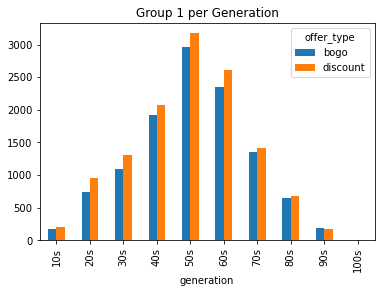

In [39]:
group_1.pivot_table('person', index='generation', columns='offer_type', aggfunc='count').plot(kind='bar');
plt.title('Group 1 per Generation');

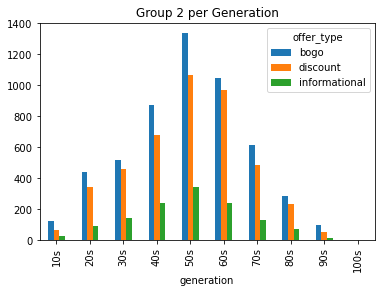

In [40]:
group_2.pivot_table('person', index='generation', columns='offer_type', aggfunc='count').plot(kind='bar');
plt.title('Group 2 per Generation');

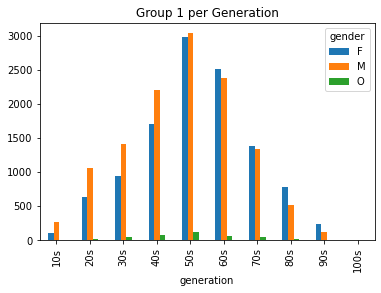

In [41]:
group_1.pivot_table('person', index='generation', columns='gender', aggfunc='count').plot(kind='bar');
plt.title('Group 1 per Generation');

> **Finding 1**: Female of older than 50s tend to complete offer given the numbers of received and reviewed.

> **Finding 2**: Others shows little interest in offer completion for all generation.

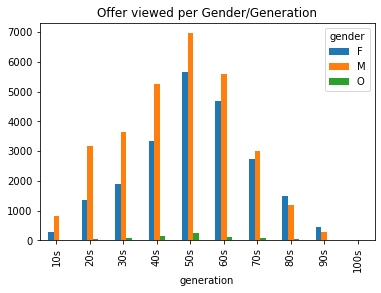

In [42]:
group_3.pivot_table('person', index='generation', columns='gender', aggfunc='count').plot(kind='bar');
plt.title('Offer viewed per Gender/Generation');

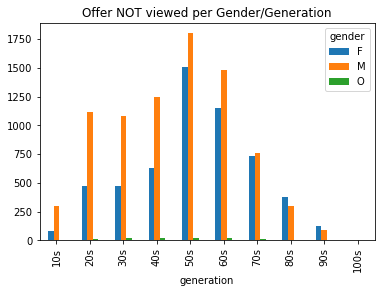

In [43]:
group_4.pivot_table('person', index='generation', columns='gender', aggfunc='count').plot(kind='bar');
plt.title('Offer NOT viewed per Gender/Generation');

In [44]:
def best_customer(df=transcript,n=15):
    
    '''
    input: df, n(rank)
    output: gende, age, income
    '''
    rank = df.groupby(['person', 'age','gender','loyalty','income']).sum()['amount'].sort_values(ascending=False)[:n]
    
    return rank

best_customer()    

person                            age   gender  loyalty  income  
3c8d541112a74af99e88abbd0692f00e  77.0  M       303.0    97000.0     1608.69
f1d65ae63f174b8f80fa063adcaa63b7  32.0  M       37.0     64000.0     1365.66
ae6f43089b674728a50b8727252d3305  36.0  F       431.0    71000.0     1327.74
626df8678e2a4953b9098246418c9cfa  53.0  M       1066.0   103000.0    1321.42
73afdeca19e349b98f09e928644610f8  50.0  M       805.0    86000.0     1319.97
52959f19113e4241a8cb3bef486c6412  55.0  M       583.0    111000.0    1292.86
ad1f0a409ae642bc9a43f31f56c130fc  66.0  M       333.0    80000.0     1258.19
d240308de0ee4cf8bb6072816268582b  43.0  F       391.0    94000.0     1251.99
946fc0d3ecc4492aa4cc06cf6b1492c3  58.0  M       417.0    79000.0     1232.40
6406abad8e2c4b8584e4f68003de148d  67.0  M       879.0    79000.0     1211.76
6cf884a6c5ae4b2daccb6d3108028fef  58.0  F       1085.0   110000.0    1165.26
8c6b2a81cb294c28b740e9c459ab7767  58.0  F       428.0    97000.0     1154.75
5ecaea5c8b

In [45]:
group_1.to_csv('group_1.csv', index=False)

# D. Mechine Learning

## 1. Principal Component Analysis

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans

df_pca = pd.read_csv('group_1.csv')

In [47]:
df_pca.head(2)

,person,offer_id,time,event,reward_x,amount,offer_type,view,complete,gender,age,became_member_on,income,generation,loyalty
0,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,252,offer completed,3.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,30s,198.0
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,576,offer completed,5.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,30s,198.0


def id_mapper(df, column):
    '''
    Create id mapper
    input: df(Dataframe)
    output:df(Dataframe)
    '''
    coded_dict = dict()
    cter = 1
    encoded = []
    
    for s in df[column]:
        if s not in coded_dict:
            coded_dict[s] = cter
            cter += 1
        
        encoded.append(coded_dict[s])               
    
    return encoded

def offer_id_mapper(df, column):
    '''
    
    '''
    encoded = id_mapper(df, column)
    del df[column]
    df[column] = encoded

    return df

df_pca = offer_id_mapper(df_pca, 'offer_id')
df_pca

In [95]:
def create_data_pca(df=df_pca):
    '''
    Create Dataframe for PCA
    - drop unnecessary columns
    - create dummy variables
    input: df(Dataframe)
    output: df(dataframe)
     '''
    df = df.drop(columns = ['reward_x','person','event','view','complete','became_member_on','generation',
                            'amount','offer_type'])
    df.dropna(axis = 0, inplace=True)
    
    # dummy = pd.get_dummies(df[['gender','offer_type']])
    # df = df.join(dummy)
    df = pd.get_dummies(df)
    
    numerical = ['time','age','income','loyalty']
    scaler = StandardScaler()
    df[numerical] = scaler.fit_transform(df[numerical])
    
    return df        
                 
data_pca = create_data_pca(df_pca)
data_pca

,time,age,income,loyalty,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2,offer_id_2906b810c7d4411798c6938adc9daaa5,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O
0,-0.747773,-0.945407,-0.563564,-0.996200,0,1,0,0,0,0,0,0,0,0,1
1,0.915640,-0.945407,-0.563564,-0.996200,1,0,0,0,0,0,0,0,0,0,1
2,0.915640,-0.945407,-0.563564,-0.996200,0,0,0,0,1,0,0,0,0,0,1
3,-1.764303,0.193975,0.994170,0.687741,0,0,0,0,0,0,0,1,1,0,0
4,0.576797,0.193975,0.994170,0.687741,0,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25010,-1.733499,-0.645569,-0.327544,0.025126,0,0,0,0,0,0,0,1,1,0,0
25011,-1.025008,-0.645569,-0.327544,0.025126,1,0,0,0,0,0,0,0,1,0,0
25012,-0.070086,-0.645569,-0.327544,0.025126,0,0,1,0,0,0,0,0,1,0,0
25013,0.083934,-0.645569,-0.327544,0.025126,0,0,1,0,0,0,0,0,1,0,0


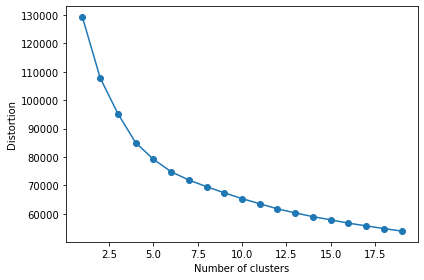

In [96]:
def elbow(X):
    '''
    plot to identify 'elbow' point for pca analysys
    input: Dataframe
    output: plot to show 'elbow'    
    '''
    distortions =[]
    for i in range(1, 20):
        km = KMeans(n_clusters = i,
                   init = 'k-means++',
                   n_init =10,
                   max_iter=300,
                   random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)
        
    plt.plot(range(1,20),distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

elbow(data_pca)

In [97]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = data_pca
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    
    return pca, X_pca

pca, X_pca = do_pca(10, data_pca)


In [98]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n%.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,time,age,income,loyalty,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2,offer_id_2906b810c7d4411798c6938adc9daaa5,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O
Dimension 1,0.2476,-0.0324,0.6905,0.7003,-0.0334,0.0050,-0.0170,0.0009,0.0184,0.0008,0.0055,0.0001,-0.0136,0.1225,-0.1215,-0.0010
Dimension 2,0.1919,-0.6872,-0.0120,0.0269,0.7240,-0.0093,-0.0002,-0.0005,0.0021,-0.0032,-0.0044,0.0081,0.0073,-0.0346,0.0351,-0.0005
Dimension 3,0.1808,0.7242,0.0585,0.0247,0.6832,0.0083,-0.0001,0.0060,-0.0095,0.0069,-0.0085,-0.0109,0.0078,-0.0442,0.0469,-0.0027
Dimension 4,0.1296,-0.0382,0.7190,-0.6875,-0.0051,-0.0032,0.0116,0.0016,-0.0149,0.0002,-0.0095,0.0033,0.0108,-0.0653,0.0634,0.0019
Dimension 5,0.0854,0.0154,-0.0518,-0.1858,0.0873,0.0009,-0.0103,-0.0036,0.0168,0.0005,0.0097,-0.0025,-0.0116,0.6899,-0.6916,0.0017
Dimension 6,0.0338,-0.0012,-0.0012,0.0010,-0.0085,-0.0093,-0.6168,-0.0187,-0.0286,-0.0196,-0.0262,-0.0638,0.7830,0.0036,-0.0023,-0.0013
Dimension 7,0.0297,0.0080,-0.0031,-0.0214,0.0064,0.0411,-0.6432,0.0898,0.1484,0.0958,0.1415,0.5714,-0.4447,-0.0162,0.0110,0.0053
Dimension 8,0.0246,0.0077,-0.0010,0.0211,-0.0046,-0.0561,0.2504,-0.1567,-0.4388,-0.1713,-0.3598,0.7138,0.2185,0.0170,-0.0142,-0.0028
Dimension 9,0.0215,-0.0051,0.0030,0.0075,0.0028,0.0123,-0.0234,0.0433,-0.7106,0.0507,0.6978,-0.0477,-0.0224,0.0031,-0.0056,0.0025
Dimension 10,0.0194,-0.0136,-0.0035,0.0072,-0.0077,0.0658,-0.0927,0.4363,-0.3653,0.6483,-0.4632,-0.1430,-0.0862,0.0035,-0.0131,0.0096


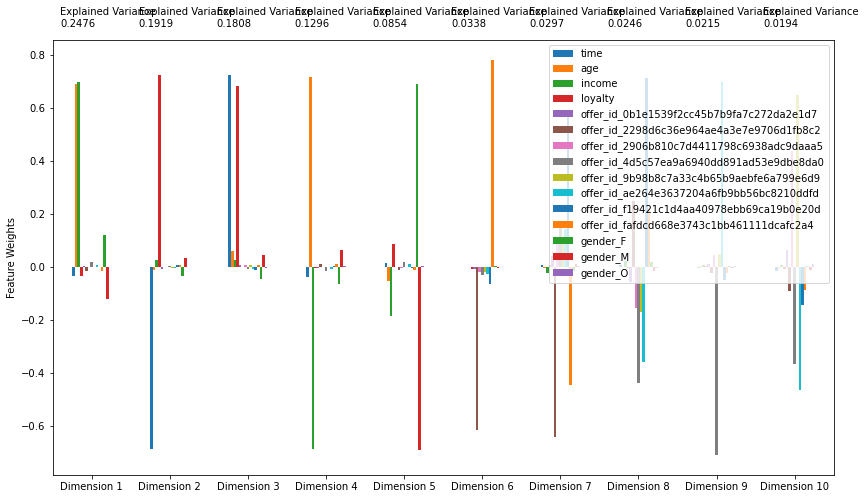

In [99]:
pca_results(data_pca,pca)

## 2. Supervised Learning 
#### *To build a model that predicts whether or not someone will respond to an offer.* 

In [100]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
import time
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import visuals as vs

In [101]:
group_view.head()

,person,offer_id,time,event,reward_x,amount,offer_type,view,complete,gender,age,became_member_on,income,generation,loyalty
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,offer viewed,NaN,NaN,bogo,1,0,M,33.0,2017-04-21,72000.0,30s,461.0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540,offer viewed,NaN,NaN,discount,1,0,M,33.0,2017-04-21,72000.0,30s,461.0
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,630,offer viewed,NaN,NaN,bogo,1,0,NaN,NaN,NaT,NaN,NaN,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,252,offer completed,3.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,30s,198.0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,576,offer completed,5.0,NaN,discount,1,1,O,40.0,2018-01-09,57000.0,30s,198.0


In [102]:
def create_data_svl(df):
    
    '''
    create data for supervised lerning whether or not someone will complete after view offer
    input: pd Dataframe 'Group'
    output: data for supervised lerning
    '''
    
    data_svl = df
    # data_svl = offer_id_mapper(data_svl,'offer_id')
    # data_svl.offer_id.astype('str')
    data_svl.reward_x.replace({'np.nan',0})
        
    data_svl = data_svl.drop(columns = ['person','event','view','generation','became_member_on','reward_x','amount',
                                       'offer_type','time'])
    
    scaler = StandardScaler()
    numerical = ['age','income','loyalty']
    data_svl[numerical] = scaler.fit_transform(data_svl[numerical]) 
    
    data_svl.dropna(axis = 0, inplace=True)
    
    data_svl = pd.get_dummies(data_svl)    
          
    return data_svl

data_svl = create_data_svl(group_view)
data_svl

,complete,age,income,loyalty,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2,offer_id_2906b810c7d4411798c6938adc9daaa5,offer_id_3f207df678b143eea3cee63160fa8bed,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_5a8bc65990b245e5a138643cd4eb9837,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O
0,0,-1.344020,0.168181,-0.290283,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0,-1.344020,0.168181,-0.290283,0,0,0,0,0,0,0,0,0,1,0,1,0
3,1,-0.927079,-0.540392,-0.940924,0,1,0,0,0,0,0,0,0,0,0,0,1
4,1,-0.927079,-0.540392,-0.940924,1,0,0,0,0,0,0,0,0,0,0,0,1
5,1,-0.927079,-0.540392,-0.940924,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37628,0,-0.629264,-0.304201,0.073383,0,0,1,0,0,0,0,0,0,0,1,0,0
37629,1,-0.629264,-0.304201,0.073383,0,0,1,0,0,0,0,0,0,0,1,0,0
37630,0,-0.629264,-0.304201,0.073383,0,0,0,0,0,0,1,0,0,0,1,0,0
37631,1,-0.629264,-0.304201,0.073383,0,0,1,0,0,0,0,0,0,0,1,0,0


In [103]:
def data_preparation(df):
    '''
    
    '''
    target_raw = df['complete']
    features_raw = df.drop('complete', axis = 1)
    
    encoder = preprocessing.LabelEncoder()
    complete = encoder.fit_transform(target_raw)
    
    X_train, X_test, y_train, y_test = train_test_split(features_raw, 
                                                    complete, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_preparation(data_svl)    

In [104]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
   
    sample_size= int(sample_size)  
    start = time.time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size]) # None
    end = time.time()  # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start # None
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time.time() # Get start time
    predictions_test = learner.predict(X_test) # None
    predictions_train = learner.predict(X_train[:300]) # None
    end = time.time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = np.sum((predictions_train[:300] == y_train[:300]) / 300 ) #None
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test) # None
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta = 0.5) # None
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5) #None
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [105]:
TP = np.sum(data_svl['complete'])
FP = data_svl['complete'].value_counts()[0]
#FP = n_at_most_50k
TN = 0
FN = 0

accuracy = TP / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5 * 0.5) * ( precision * recall) / ((0.5 * 0.5 * precision) + recall)


LogisticRegression trained on 282 samples.
LogisticRegression trained on 2829 samples.
LogisticRegression trained on 28294 samples.
SVC trained on 282 samples.
SVC trained on 2829 samples.
SVC trained on 28294 samples.
AdaBoostClassifier trained on 282 samples.
AdaBoostClassifier trained on 2829 samples.
AdaBoostClassifier trained on 28294 samples.


C:\Users\wythe\Starbucks\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


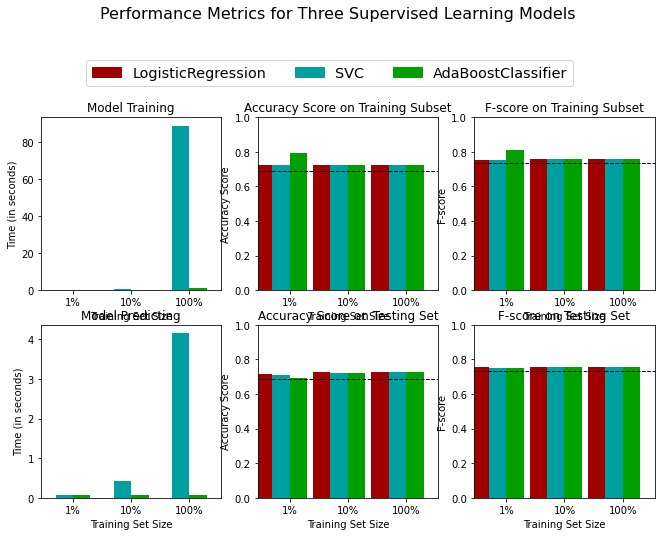

In [106]:
# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=42)
clf_B = SVC(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [107]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

# TODO: Initialize the classifier
clf =  AdaBoostClassifier(random_state=42)# None

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

parameters =  {"base_estimator" : [DecisionTreeClassifier(max_depth=x) 
                                  for x in range(5, 10)],
              "learning_rate" : [0.5, 1.0, 1.5]}
    

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5) #None

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer) # None

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train) # None

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.7248
F-score on testing data: 0.7574

Optimized Model
------
Final accuracy score on the testing data: 0.7081
Final F-score on the testing data: 0.7531


In [108]:
best_clf

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.5, random_state=42)

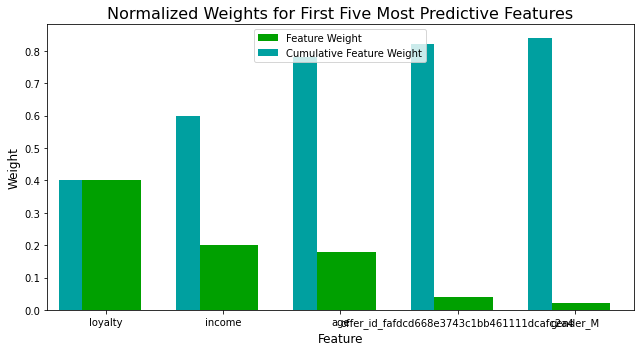

In [109]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.datasets import make_classification


#TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = clf.feature_importances_ # None

# Plot
vs.feature_plot(importances, X_train, y_train)

In [110]:
indices = np.argsort(importances)[::-1]
X_train.columns.values[indices[:8]]

array(['loyalty', 'income', 'age',
       'offer_id_fafdcd668e3743c1bb461111dcafc2a4', 'gender_M',
       'offer_id_ae264e3637204a6fb9bb56bc8210ddfd',
       'offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer_id_5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [111]:
portfolio


,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [112]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.7081
F-score on testing data: 0.7531

Final Model trained on reduced data
------
Accuracy on testing data: 0.6695
F-score on testing data: 0.7277


## Analysys viw or not view

In [122]:
group_notview.head()

,person,offer_id,offer_type,viewed,mail_mb_sns,wb_mail_mb_sns,wb_mail_mb,wb_mail,gender,age,became_member_on,income,generation,loyalty
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,informational,1,1,0,0,0,M,33.0,2017-04-21,72000.0,30s,461.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,informational,1,0,0,1,0,M,33.0,2017-04-21,72000.0,30s,461.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,0,1,0,0,M,33.0,2017-04-21,72000.0,30s,461.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1,0,1,0,0,M,33.0,2017-04-21,72000.0,30s,461.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,0,0,0,1,0,M,33.0,2017-04-21,72000.0,30s,461.0


In [125]:
def create_data_notview(df):
    
    '''
    create data for supervised lerning whether or not someone will complete after view offer
    input: pd Dataframe 'Group'
    output: data for supervised lerning
    '''
            
    df = df.drop(columns = ['person','offer_id','offer_type','generation','became_member_on'])
    
    scaler = StandardScaler()
    numerical = ['age','income','loyalty']
    df[numerical] = scaler.fit_transform(df[numerical]) 
    
    df.dropna(axis = 0, inplace=True)
    
    df = pd.get_dummies(df)    
          
    return df

data_notview = create_data_notview(group_notview)
data_notview

,viewed,mail_mb_sns,wb_mail_mb_sns,wb_mail_mb,wb_mail,age,income,loyalty,gender_F,gender_M,gender_O
0,1,1,0,0,0,-1.228450,0.306541,-0.145275,0,1,0
1,1,0,0,1,0,-1.228450,0.306541,-0.145275,0,1,0
2,1,0,1,0,0,-1.228450,0.306541,-0.145275,0,1,0
3,1,0,1,0,0,-1.228450,0.306541,-0.145275,0,1,0
4,0,0,0,1,0,-1.228450,0.306541,-0.145275,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
76272,1,0,0,0,1,-0.538609,-0.155927,0.205381,1,0,0
76273,1,0,0,1,0,-0.538609,-0.155927,0.205381,1,0,0
76274,1,0,0,1,0,-0.538609,-0.155927,0.205381,1,0,0
76275,1,0,0,1,0,-0.538609,-0.155927,0.205381,1,0,0


In [127]:
def data_preparation(df):
    '''
    
    '''
    target_raw = df['viewed']
    features_raw = df.drop('viewed', axis = 1)
    
    encoder = preprocessing.LabelEncoder()
    complete = encoder.fit_transform(target_raw)
    
    X_train, X_test, y_train, y_test = train_test_split(features_raw, 
                                                    complete, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_preparation(data_notview)    

In [128]:
TP = np.sum(data_notview['viewed'])
FP = data_notview['viewed'].value_counts()[0]
#FP = n_at_most_50k
TN = 0
FN = 0

accuracy = TP / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5 * 0.5) * ( precision * recall) / ((0.5 * 0.5 * precision) + recall)


LogisticRegression trained on 532 samples.
LogisticRegression trained on 5320 samples.
LogisticRegression trained on 53200 samples.
SVC trained on 532 samples.
SVC trained on 5320 samples.
SVC trained on 53200 samples.
AdaBoostClassifier trained on 532 samples.
AdaBoostClassifier trained on 5320 samples.
AdaBoostClassifier trained on 53200 samples.


C:\Users\wythe\Starbucks\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


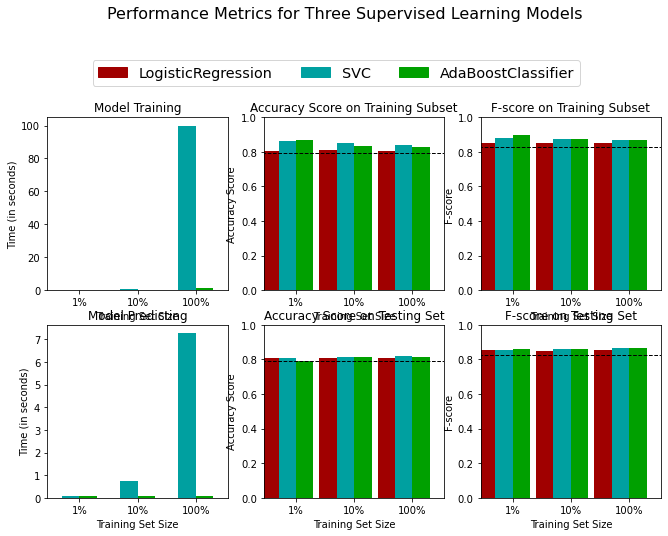

In [129]:
# TODO: Initialize the three models
clf_A = LogisticRegression(random_state=42)
clf_B = SVC(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [130]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

# TODO: Initialize the classifier
clf =  AdaBoostClassifier(random_state=42)# None

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}

parameters =  {"base_estimator" : [DecisionTreeClassifier(max_depth=x) 
                                  for x in range(5, 10)],
              "learning_rate" : [0.5, 1.0, 1.5]}
    

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5) #None

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer) # None

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train) # None

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8166
F-score on testing data: 0.8633

Optimized Model
------
Final accuracy score on the testing data: 0.8157
Final F-score on the testing data: 0.8716


In [131]:
best_clf

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=6),
                   learning_rate=0.5, random_state=42)

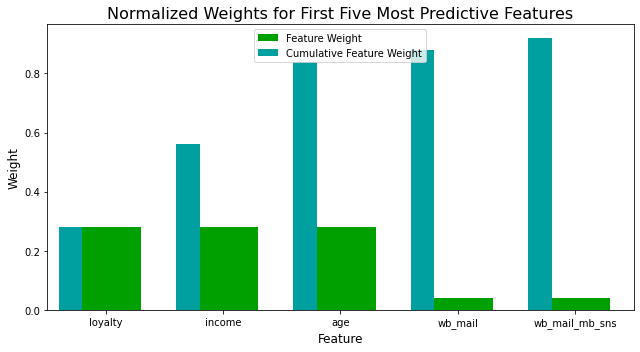

In [132]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.datasets import make_classification


#TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = clf.feature_importances_ # None

# Plot
vs.feature_plot(importances, X_train, y_train)

In [133]:
indices = np.argsort(importances)[::-1]
X_train.columns.values[indices[:8]]

array(['loyalty', 'income', 'age', 'wb_mail', 'wb_mail_mb_sns',
       'mail_mb_sns', 'gender_O', 'gender_F'], dtype=object)

## 3. Logistic Regression Analyss
#### *To build a model that predicts whether or not someone will respond to an offer.* 

In [79]:
import statsmodels.api as sm

In [80]:
portfolio.offer_id.values

array(['ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5'], dtype=object)

In [81]:
data_LR = data_svl.sample(5000)
data_LR['intercept'] = 1
data_LR.head()

,complete,age,income,loyalty,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2,offer_id_2906b810c7d4411798c6938adc9daaa5,offer_id_3f207df678b143eea3cee63160fa8bed,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_5a8bc65990b245e5a138643cd4eb9837,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O,intercept
13606,1,-1.880088,-1.390680,-0.750432,0,0,0,0,0,0,1,0,0,0,1,0,0,1
35204,1,-0.391011,0.640563,-0.559940,0,0,0,0,0,0,0,0,1,0,1,0,0,1
9707,1,0.859813,0.971231,-0.747958,0,0,0,0,0,0,0,0,1,0,1,0,0,1
36661,1,2.170200,-1.485156,-0.859285,0,0,0,0,1,0,0,0,0,0,1,0,0,1
10012,0,0.145056,2.104948,-0.673741,0,0,0,0,0,0,0,0,1,0,1,0,0,1


In [90]:
data_LR.columns

Index(['complete', 'age', 'income', 'loyalty',
       'offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offer_id_2906b810c7d4411798c6938adc9daaa5',
       'offer_id_3f207df678b143eea3cee63160fa8bed',
       'offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offer_id_5a8bc65990b245e5a138643cd4eb9837',
       'offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer_id_ae264e3637204a6fb9bb56bc8210ddfd',
       'offer_id_f19421c1d4aa40978ebb69ca19b0e20d',
       'offer_id_fafdcd668e3743c1bb461111dcafc2a4', 'gender_F', 'gender_M',
       'gender_O', 'intercept'],
      dtype='object')

In [93]:
logit_mod = sm.Logit(data_LR['complete'],
                    data_LR[['intercept','age', 'income', 'loyalty',
       'offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offer_id_2906b810c7d4411798c6938adc9daaa5',
       'offer_id_3f207df678b143eea3cee63160fa8bed',
       'offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offer_id_5a8bc65990b245e5a138643cd4eb9837',
       'offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer_id_ae264e3637204a6fb9bb56bc8210ddfd',
       'offer_id_fafdcd668e3743c1bb461111dcafc2a4']])
results = logit_mod.fit()

         Current function value: 0.571808
         Iterations: 35


C:\Users\wythe\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [94]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                     Results: Logit
========================================================================================================================
Model:                                 Logit                              Pseudo R-squared:                   0.078     
Dependent Variable:                    complete                           AIC:                                5744.0806 
Date:                                  2021-01-09 17:56                   BIC:                                5828.8041 
No. Observations:                      5000                               Log-Likelihood:                     -2859.0   
Df Model:                              12                                 LL-Null:                            -3100.3   
Df Residuals:                          4987                               LLR p-value:                        1.1748e-95
Converged:                             0.0000                             Scale:                              1.0000    
No. Iterations:                        35.0000                                                                          
------------------------------------------------------------------------------------------------------------------------
                                           Coef.        Std.Err.        z    P>|z|        [0.025             0.975]     
------------------------------------------------------------------------------------------------------------------------
intercept                                   0.8774            0.0828 10.6017 0.0000             0.7152            1.0396
age                                         0.0176            0.0342  0.5131 0.6079            -0.0495            0.0846
income                                      0.0555            0.0340  1.6299 0.1031            -0.0112            0.1222
loyalty                                     0.1882            0.0337  5.5828 0.0000             0.1221            0.2543
offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7   0.4708            0.1645  2.8621 0.0042             0.1484            0.7933
offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2   0.1097            0.1150  0.9535 0.3404            -0.1158            0.3351
offer_id_2906b810c7d4411798c6938adc9daaa5   0.0187            0.1290  0.1447 0.8849            -0.2342            0.2716
offer_id_3f207df678b143eea3cee63160fa8bed -19.4752         1584.1053 -0.0123 0.9902         -3124.2646         3085.3142
offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0  -0.0745            0.1204 -0.6192 0.5358            -0.3105            0.1614
offer_id_5a8bc65990b245e5a138643cd4eb9837 -59.0722 395332674492.0883 -0.0000 1.0000 -774837803975.4618 774837803857.3175
offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9   0.1270            0.1320  0.9618 0.3361            -0.1318            0.3857
offer_id_ae264e3637204a6fb9bb56bc8210ddfd  -0.3448            0.1184 -2.9112 0.0036            -0.5769           -0.1126
offer_id_fafdcd668e3743c1bb461111dcafc2a4   0.2129            0.1155  1.8429 0.0653            -0.0135            0.4393
========================================================================================================================

"""

In [88]:
np.exp(-0.3405), np.exp(0.2096), np.exp(-0.1376)

(0.711414526557692, 1.2331846874138475, 0.8714472009196846)

In [ ]:
1/np.exp(-0.3405), 1/np.exp(-0.1376)

- complete decrease 1.4 times time goes on
- complete increase 1.23 times customers for old age
- complete decrease 1.14 times offer_id(need to check)

## 4. Linear Regression Analyss
#### *To build a machine learning model that predicts how much someone will spend based on demographics and offer type.* 

In [ ]:
#events_filter('transaction', transcript)

In [ ]:
def create_data_LinearR(df=transcript):
    
    '''
    create data for Linear Rigression supervised to predict 
    how much someone will spend based on demographics and offer type 
    input: pd Dataframe 'Group'
    output: data for supervised lerning
    '''
    data_LinearR = events_filter('transaction', df)
    #data_LinearR.dropna(axis=0, inplace=True)
    data_LinearR = data_LinearR.drop(columns = (['person','event','value','generation','offer_id','generation',
                                                'became_member_on','reward_x', 'reward_y','channels','difficulty',
                                                'duration','offer_type']))
   
    data_LinearR.dropna(inplace=True)
        
    data_LinearR = pd.get_dummies(data_LinearR)    
    data_LinearR['intercept'] = 1
    
    return data_LinearR

data_LinearR = create_data_LinearR()
data_LinearR

In [ ]:
data_LinearR.info()

In [ ]:
logit_mod = sm.OLS(data_LinearR['amount'],
                    data_LinearR[['intercept','time','income','loyalty','age','gender_F','gender_O','gender_M']])
results = logit_mod.fit()

In [ ]:
results.summary()

### Sklearn

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
data_LinearR = data_LinearR[['amount','time','income','loyalty','age','gender_F','gender_O']]

In [ ]:
y = data_LinearR['amount'].values
X = data_LinearR.drop(labels = ['amount'], axis = 1).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state = 0, straitify = y)

In [ ]:
sc_x = StandardScaler()
sc_y = StandardScaler()

In [ ]:
X_train_std = sc_x.fit_transform(X_train)
X_test_std = sc_y.transform(X_test)
X_train_std

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
model.coef_

In [ ]:
plt.figure(figsize=(10,7))
plt.bar(X = columns, height = model.coef_);

In [ ]:
model.intercept_

In [ ]:
print('train score:{}'.format(model.score(X_train, y_train)))
print('test score:{}'.format(model.score(X_test, y_test)))

In [ ]:
y = model.predict(X_test)

In [ ]:
print('prediction value: {}'.format(y[0]))
print('target value: {}'.format(y_test[150]))

In [ ]:
df_corr = data_LinearR.corr()
df_corr.head()

In [ ]:
plt.figure(figsize=(12,8))
sb.heatmap(df_corr.iloc[:20,:20], annot=True);

In [ ]:
sb.jointplot(x='gender_M', y='gender_F', data = data_LinearR);

In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components = 4)
pls.fit(X_train, y_train)

In [ ]:
print('train score: {}'.format(pls.score(X_train, y_train)))
print('test score: {}'.format(pls.score(X_test, y_test)))